# Study VR2F — **Behavioral results**
    Author:  Felix Klotzsche  
    Year:     2024-2025

In [4]:
import os
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from vr2f.behavior.maintask import get_confusion_matrix, plot_confusion_matrix
from vr2f.behavior.intensity_rating import get_intensity_ratings
from vr2f.staticinfo import COLORS, PATHS
from vr2f.helpers import format_float


In [2]:
%reload_ext autoreload
%autoreload 2

# 1. Confusion matrices
First, we plot the behavioral confusion matrices: 

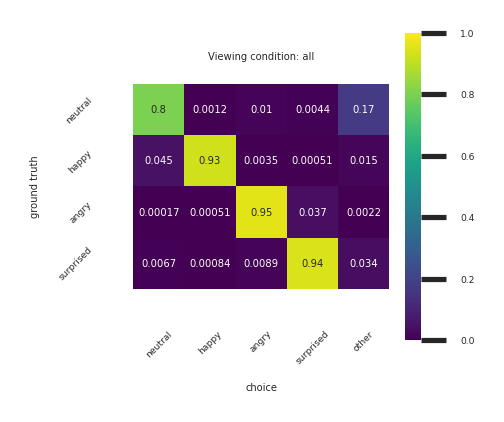

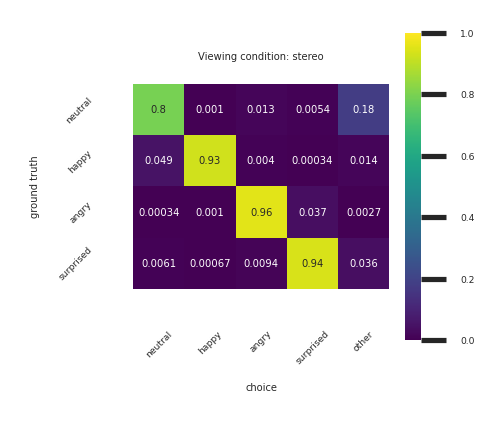

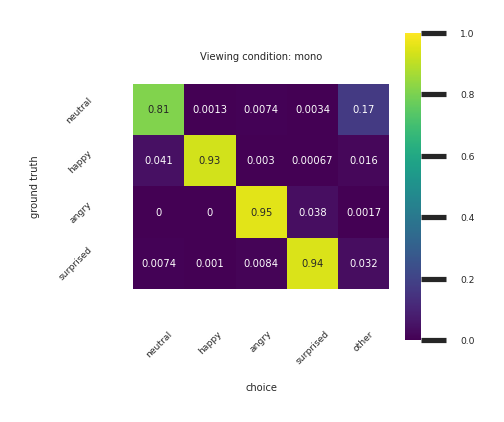

In [10]:
paths = PATHS()

path_subs = paths.DATA_SUBJECTS

sub_list_str = sorted(glob.glob("VR2FEM_*", root_dir=path_subs))


subs_incomplete = ["VR2FEM_S09"]
sub_list_str = [s for s in sub_list_str if s not in subs_incomplete]

cfs = {"all": [], "stereo": [], "mono": []}
for sub_id in sub_list_str:
    for cond in cfs:
        cf = get_confusion_matrix(sub_id, cond)
        cfs[cond].append(cf)

# Average across subjects
cf_avg = {}
for cond in cfs:
    cf_avg[cond] = np.array(cfs[cond]).mean(axis=0)
    o = plot_confusion_matrix(cf_avg, cond, save_to_disk=True, figsize_factor=0.2, show_numbers=True)



In [6]:
emotions = ["neutral", "angry", "happy", "surprised"]

df_accs = pd.DataFrame(columns=["sub_id", "viewcond", "emotion", "acc"])
for cond in ["all", "stereo", "mono"]:
  for idx, cf in enumerate(cfs[cond]):
    accs = np.diagonal(cf)[:-1]
    df = pd.DataFrame(columns=["sub_id", "viewcond", "emotion", "acc"])
    df["sub_id"] = [sub_list_str[idx]] * len(accs)
    df["viewcond"] = [cond] * len(accs)
    df["emotion"] = emotions
    df["acc"] = accs
    df_accs = df if df_accs.empty else pd.concat([df_accs, df])

convert_dict = {"sub_id": str, "viewcond": str, "emotion": str, "acc": float}
df_accs = df_accs.astype(convert_dict)

paths = PATHS()
df_accs.to_csv(Path(paths.RESULTS, "dataframes", "behavior", "behavior_accs.csv"), index=False)

## 1.1. rmANOVA: accuarcy ~ emotion * viewing condition

In [7]:
aov = AnovaRM(df_accs,
          depvar = "acc",
          subject = "sub_id",
          within = ["viewcond", "emotion"]).fit()
print(aov)


                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
viewcond          1.8510 2.0000  64.0000 0.1654
emotion           6.8133 3.0000  96.0000 0.0003
viewcond:emotion  1.3658 6.0000 192.0000 0.2303



## 1.2 Summary stats

In [9]:
summary = df_accs.agg({"acc": ["mean", "std", "sem", "min", "max"]})
summary.loc["ci_lower","acc"] = summary.loc["mean","acc"] - 1.96 * summary.loc["sem","acc"]
summary.loc["ci_upper","acc"] = summary.loc["mean","acc"] + 1.96 * summary.loc["sem","acc"]
print(summary)


m = summary.loc["mean", "acc"]
std = summary.loc["std", "acc"]
ci_l = summary.loc["ci_lower", "acc"]
ci_u = summary.loc["ci_upper", "acc"]

txt = f"""
M = {format_float(m * 100) }%, SD = {format_float(std* 100)}, 95% CI [{format_float(ci_l * 100)}, {format_float(ci_u * 100)}]
"""
print(txt)

               acc
mean      0.907323
std       0.169827
sem       0.008534
min       0.122222
max       1.000000
ci_lower  0.890596
ci_upper  0.924050

M = 90.73%, SD = 16.98, 95% CI [89.06, 92.41]



In [10]:
summary = df_accs.groupby(["emotion"]).agg({"acc": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("acc", "ci_lower")] = summary[("acc", "mean")] - 1.96 * summary[("acc", "sem")]
summary.loc[:, ("acc", "ci_upper")] = summary[("acc", "mean")] + 1.96 * summary[("acc", "sem")]

summary


emotion       acc                                                       
                  mean       std       sem       min  max  ci_lower  ci_upper
0      angry  0.929293  0.150958  0.015172  0.222222  1.0  0.899556  0.959030
1      happy  0.954882  0.059467  0.005977  0.733333  1.0  0.943168  0.966596
2    neutral  0.803199  0.249099  0.025035  0.122222  1.0  0.754129  0.852268
3  surprised  0.941919  0.113748  0.011432  0.377778  1.0  0.919512  0.964326

In [11]:
summary = df_accs.groupby(["viewcond", "emotion"]).agg({"acc": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("acc", "ci_lower")] = summary[("acc", "mean")] - 1.96 * summary[("acc", "sem")]
summary.loc[:, ("acc", "ci_upper")] = summary[("acc", "mean")] + 1.96 * summary[("acc", "sem")]

summary

viewcond    emotion       acc                                               \
                            mean       std       sem       min  max  ci_lower   
0       all      angry  0.929293  0.151817  0.026428  0.222222  1.0  0.877494   
1       all      happy  0.954882  0.058840  0.010243  0.777778  1.0  0.934807   
2       all    neutral  0.803199  0.251155  0.043720  0.144444  1.0  0.717507   
3       all  surprised  0.941919  0.114008  0.019846  0.438889  1.0  0.903020   
4      mono      angry  0.930640  0.147302  0.025642  0.222222  1.0  0.880382   
5      mono      happy  0.954545  0.062938  0.010956  0.733333  1.0  0.933072   
6      mono    neutral  0.810438  0.252273  0.043915  0.122222  1.0  0.724364   
7      mono  surprised  0.942761  0.110558  0.019246  0.500000  1.0  0.905039   
8    stereo      angry  0.927946  0.158239  0.027546  0.222222  1.0  0.873956   
9    stereo      happy  0.955219  0.058365  0.010160  0.800000  1.0  0.935305   
10   stereo    neutral  0.795960  0.251398  0.043763  0.166667  1.0  0.710185   
11   stereo  surprised  0.941077  0.120008  0.020891  0.377778  1.0  0.900132   

              
    ci_upper  
0   0.981092  
1   0.974958  
2   0.888891  
3   0.980818  
4   0.980898  
5   0.976019  
6   0.896511  
7   0.980483  
8   0.981936  
9   0.975133  
10  0.881735  
11  0.982023

In [12]:
summary = df_accs.groupby(["viewcond"]).agg({"acc": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("acc", "ci_lower")] = summary[("acc", "mean")] - 1.96 * summary[("acc", "sem")]
summary.loc[:, ("acc", "ci_upper")] = summary[("acc", "mean")] + 1.96 * summary[("acc", "sem")]
m = {}
sd = {}
ci_l = {}
ci_u = {}
for vc in ["stereo", "mono"]:
  m[vc], sd[vc], ci_l[vc], ci_u[vc] = summary.loc[summary["viewcond"] == vc, ("acc", ("mean", "std", "ci_lower", "ci_upper"))].values[0]
  m[vc], sd[vc], ci_l[vc], ci_u[vc] = format_float(m[vc] * 100), format_float(sd[vc] * 100), format_float(ci_l[vc] * 100), format_float(ci_u[vc] * 100)


txt = f"""
We did not observe a difference in recognition rate for the mono- (M = {m['mono']} %, SD = {sd['mono']}, 95% CI [{ci_l['mono']}, {ci_u['mono']}])
and the stereoscopic viewing conditions (M = {m['stereo']} %, SD = {sd['stereo']}, 95% CI [{ci_l['stereo']}, {ci_u['stereo']}]), as indicated by a non-significant main effect of viewing condition
(F(2, 64) = 1.85, p = .165) and a non-significant interaction (F(6, 192) = 1.37, p = .230) with the emotional expression.
"""
print(txt.replace("\n", " "))

 We did not observe a difference in recognition rate for the mono- (M = 90.96 %, SD = 16.79, 95% CI [88.10, 93.82]) and the stereoscopic viewing conditions (M = 90.51 %, SD = 17.32, 95% CI [87.55, 93.46]), as indicated by a non-significant main effect of viewing condition (F(2, 64) = 1.85, p = .165) and a non-significant interaction (F(6, 192) = 1.37, p = .230) with the emotional expression. 


In [13]:
# Summary for the (highest) confusion: neutral vs other
df_conf = pd.DataFrame(columns=["sub_id", "viewcond", "confusion"])
for cond in ["all", "stereo", "mono"]:
  for idx, cf in enumerate(cfs[cond]):
    conf = cf[0, -1] * 100
    df = pd.DataFrame(columns=["sub_id", "viewcond", "confusion"])
    df["sub_id"] = [sub_list_str[idx]]
    df["viewcond"] = [cond]
    df["confusion"] = [conf]
    df_conf = df if df_conf.empty else pd.concat([df_conf, df])

summary = df_conf.groupby(["viewcond"]).agg({"confusion": ["mean", "std", "sem", "min", "max"]}).reset_index()
summary.loc[:, ("confusion", "ci_lower")] = summary[("confusion", "mean")] - 1.96 * summary[("confusion", "sem")]
summary.loc[:, ("confusion", "ci_upper")] = summary[("confusion", "mean")] + 1.96 * summary[("confusion", "sem")]
m, sd, ci_l, ci_u = summary.loc[summary["viewcond"]=="all", ("confusion", ("mean", "std", "ci_lower", "ci_upper"))].values[0]
m, sd, ci_l, ci_u = format_float(m), format_float(sd), format_float(ci_l), format_float(ci_u)



f"""which was most often also classified as “other” (confusion rate: M = {m}%, SD = {sd}, 95% CI [{ci_l}, {ci_u}])."""



'which was most often also classified as “other” (confusion rate: M = 17.39%, SD = 23.51, 95% CI [9.37, 25.41]).'

# 2. Intensity (arousal) ratings

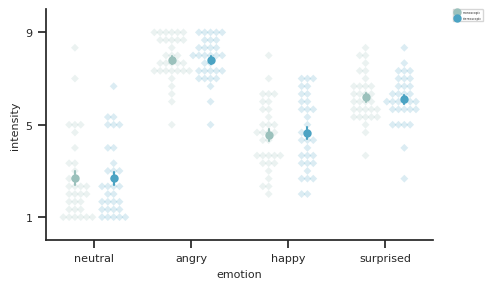

In [16]:
colors = COLORS()

df_ratings = get_intensity_ratings()

df_plt = df_ratings.groupby(["sub_id", "viewcond", "emotion"]).mean().reset_index()

df_plt["emotion"] = pd.Categorical(df_plt["emotion"], categories=["neutral", "angry", "happy", "surprised"],
                                   ordered=True)
df_plt.sort_values(by=["emotion"])

fig, ax = plt.subplots(figsize=(5, 3))

sns.set_style("ticks")

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 8
# set label font size
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

o = sns.pointplot(
    data=df_plt.reset_index(),
    x="emotion",
    y="intensity",
    hue="viewcond",
    errorbar="se",
    dodge=0.4,
    palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=4,
    err_kws={"linewidth": 1.5},
    ax=ax
    )
o = sns.swarmplot(data=df_plt, x="emotion", y="intensity", hue="viewcond", dodge=True,
                  palette=colors.COLDICT, size=4,
                  marker="D",
                  alpha=0.2)
handles, labels = o.get_legend_handles_labels()

ax.set_ylim(0, 10)
ax.set_yticks([1,5,9])

plt.legend(title="", handles=handles[:2], labels=["monoscopic", "stereoscopic"])
sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

plt.savefig(Path(paths.RESULTS, "figures", "behavior", "intensity_ratings.pdf"),
           bbox_inches="tight", dpi=300)

In [17]:
df_ratings_full = get_intensity_ratings()
df_aov = df_ratings.groupby(["sub_id", "viewcond", "emotion", "avatar"]).mean().reset_index()
df_aov["emotion"] = pd.Categorical(df_aov["emotion"], categories=["neutral", "angry", "happy", "surprised"], ordered=True)
#df_aov["avatar"] = pd.Categorical(df_aov["avatar"], categories=["id1", "id2", "id3"], ordered=True)
df_aov.sort_values(by=["avatar"])
df_aov.head()

,sub_id,viewcond,emotion,avatar,trial_num,intensity,response_time
0,VR2FEM_S01,mono,angry,1,15.0,8.0,2.131962
1,VR2FEM_S01,mono,angry,2,5.0,8.0,1.155249
2,VR2FEM_S01,mono,angry,3,3.0,8.0,2.565884
3,VR2FEM_S01,mono,happy,1,12.0,2.0,1.955770
4,VR2FEM_S01,mono,happy,2,1.0,3.0,17.778379


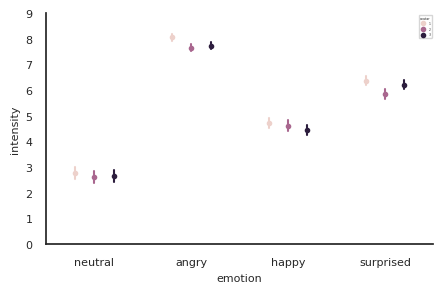

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8
# set label font size
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

sns.set_style("white")

o = sns.pointplot(
    data=df_aov.reset_index(),
    x="emotion",
    y="intensity",
    hue="avatar",
    errorbar="se",
    dodge=0.4,
    #palette=colors.COLDICT,
    linestyles="None",
    markers="o",
    markersize=2,
    err_kws={"linewidth": 1.5},
    ax=ax,
    )
plt.rcParams["font.family"] = "sans-serif"
# o = sns.swarmplot(data=df_aov, x="emotion", y="intensity", hue="avatar", dodge=True,
#                   #palette=colors.COLDICT,
#                   size=4,
#                   marker="D",
#                   alpha=0.2)
handles, labels = o.get_legend_handles_labels()
ax.set_ylim(0, 9)

# plt.legend(title="", handles=handles[:2], labels=["monoscopic", "stereoscopic"])
#  sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

plt.savefig(Path(paths.RESULTS, "figures", "behavior", "intensity_ratings_per-identity.pdf"),
              bbox_inches="tight", dpi=300)


## 2.1 rmANOVA: intensity ~ emotion * viewing condition

In [22]:

aov = AnovaRM(df_ratings.groupby(["sub_id", "viewcond", "emotion"]).mean().reset_index(),
          depvar = "intensity",
          subject = "sub_id",
          within = ["viewcond", "emotion"]).fit()
print(aov)


                     Anova
                 F Value  Num DF  Den DF Pr > F
-----------------------------------------------
viewcond           0.0074 1.0000 31.0000 0.9320
emotion          118.9475 3.0000 93.0000 0.0000
viewcond:emotion   0.3434 3.0000 93.0000 0.7940



In [21]:
aov = AnovaRM((df_ratings
               .drop("viewcond", axis=1)
               .groupby(["sub_id", "emotion", "avatar"])
               .mean()
               .reset_index()),
          depvar = "intensity",
          subject = "sub_id",
          within = ["emotion", "avatar"]).fit()
print(aov)

                    Anova
               F Value  Num DF  Den DF  Pr > F
----------------------------------------------
emotion        118.9475 3.0000  93.0000 0.0000
avatar           4.1514 2.0000  62.0000 0.0203
emotion:avatar   0.8932 6.0000 186.0000 0.5010



In [23]:
# extract ANOVA results for text
F = {}
p = {}
df_0 = {}
df_1 = {}
for fac in ["viewcond", "emotion", "viewcond:emotion"]:
    F[fac] = format_float(aov.anova_table["F Value"][fac])
    p[fac] = format_float(aov.anova_table["Pr > F"][fac], is_pval=True)
    df_0[fac] = int(aov.anova_table["Num DF"][fac])
    df_1[fac] = int(aov.anova_table["Den DF"][fac])


# Extract descriptive statistics for text
m = {}
sd = {}
ci_l = {}
ci_u = {}

df_ss = (df_ratings
          .loc[:, ["sub_id", "emotion", "intensity"]]
          .groupby(["sub_id", "emotion"]).mean().reset_index()
)

for emotion in ["neutral", "angry", "happy", "surprised"]:
  summary = df_ss.groupby(["emotion"]).agg({"intensity": ["mean", "std", "sem", "min", "max"]}).reset_index()
  summary.loc[:, ("intensity", "ci_lower")] = summary[("intensity", "mean")] - 1.96 * summary[("intensity", "sem")]
  summary.loc[:, ("intensity", "ci_upper")] = summary[("intensity", "mean")] + 1.96 * summary[("intensity", "sem")]
  m[emotion], sd[emotion], ci_l[emotion], ci_u[emotion] = summary.loc[summary["emotion"] == emotion, ("intensity", ("mean", "std", "ci_lower", "ci_upper"))].values[0]
  m[emotion], sd[emotion], ci_l[emotion], ci_u[emotion] = format_float(m[emotion]), format_float(sd[emotion]), format_float(ci_l[emotion]), format_float(ci_u[emotion])


txt_ratings = f"""
To control for the experienced level of intensity, at the end of the experiment, we asked participants to rate for 
each of the 24 stimuli (4 emotions, 3 avatar identities, 2 viewing conditions) the intensity of the displayed emotional 
face expression using the 9-point SAM rating scale for arousal. We observed a significant main effect of emotion 
(F({df_0["emotion"]},{df_1["emotion"]}) = {F["emotion"]}, p = {p["emotion"]}). 
Angry faces received the highest intensity ratings (M = {m["angry"]}, SD = {sd["angry"]}, 95% CI [{ci_l["angry"]}, {ci_u["angry"]}]), 
while neutral faces received the lowest (M = {m["neutral"]}, SD = {sd["neutral"]}, 95% CI [{ci_l["neutral"]}, {ci_u["neutral"]}]). 
Happy (M = {m["happy"]}, SD = {sd["happy"]}, 95% CI [{ci_l["happy"]}, {ci_u["happy"]}]) and 
surprised faces (M = {m["surprised"]}, SD = {sd["surprised"]}, 95% CI [{ci_l["surprised"]}, {ci_u["surprised"]}]) fell 
in between. Neither the main effect of viewing condition (F({df_0["viewcond"]},{df_1["viewcond"]}) = {F["viewcond"]}, p {p["viewcond"]}) 
nor its interaction with the emotion was significant (F({df_0["viewcond:emotion"]},{df_1["viewcond:emotion"]}) = {F["viewcond:emotion"]}, p {p["viewcond:emotion"]}).
""" 

print(txt_ratings.replace("\n", ""))

To control for the experienced level of intensity, at the end of the experiment, we asked participants to rate for each of the 24 stimuli (4 emotions, 3 avatar identities, 2 viewing conditions) the intensity of the displayed emotional face expression using the 9-point SAM rating scale for arousal. We observed a significant main effect of emotion (F(3,93) = 118.95, p = < .001). Angry faces received the highest intensity ratings (M = 7.82, SD = 0.93, 95% CI [7.50, 8.14]), while neutral faces received the lowest (M = 2.69, SD = 1.66, 95% CI [2.11, 3.26]). Happy (M = 4.60, SD = 1.47, 95% CI [4.09, 5.11]) and surprised faces (M = 6.15, SD = 0.96, 95% CI [5.81, 6.48]) fell in between. Neither the main effect of viewing condition (F(1,31) = 0.01, p = .932) nor its interaction with the emotion was significant (F(3,93) = 0.34, p = .794).
